## Prepare data in Colab enviornment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! mkdir data
# ! mkdir data/tid2013
# ! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/tid2013/distorted_images ./data/tid2013/
# ! cp drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/tid2013/mos_with_names.txt ./data/tid2013/
! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data .
! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/nima .


#### Install libraries

In [8]:
! pip install livelossplot kaggle --quiet

In [12]:
# ! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/.kaggle ~
# ! cp ./data/dataset-metadata.json .
! zip -r nima_dataset.zip ./data
# # ! kaggle datasets init -p ./nima_dataset.zip
# ! kaggle datasets create -p ./nima_dataset.zip

In [4]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras

# Start : In local docker only
import sys
sys.path.append('../')
# End : In local docker only


import nima as nima

### Load Dataset

In [ ]:
from nima.utils.tid_dataset_utils import load_tid_data
from nima.config import DATASET_DIR
from nima.utils.ava_downloader import print_msg

p_dataset_dir = DATASET_DIR
p_model_name = 'vgg'
p_batch_size = 64
p_epochs = 5
p_sample_size=1000
p_metrics = ['mean_absolute_error']
p_verbose = 1
p_freeze_base = True

tid_dataset_dir = os.path.join(p_dataset_dir, 'tid2013')
tid_images_dir = os.path.join(tid_dataset_dir, 'distorted_images')
img_format = 'bmp'
print_msg(f'Images directory {tid_images_dir}')

# Load the dataset
x_col, y_cols = 'image_id', 'rating'
df_train, df_valid, df_test = load_tid_data(tid_dataset_dir, p_sample_size)
assert len(df_train) > 0 and len(df_valid) > 0 and len(df_test) > 0, 'Empty dataframe'
train_batch_size = valid_batch_size = p_batch_size
test_batch_size = min(p_batch_size, 32, len(df_test))

df_train.head()

Images directory C:\Users\amaindola\Google Drive\Colab Notebooks\img-quality-assesment\data\tid2013\distorted_images
	Number of samples picked 1000


,rating,image_id
0,3.94737,i16_18_5
1,4.34286,i11_17_3
2,5.33333,i08_05_1
3,5.58537,i05_16_3
4,5.75000,i24_17_1


In [5]:
! pwd

/content


,rating
count,720.000000
mean,4.511687
std,1.215239
min,0.416670
25%,3.638257
50%,4.627885
75%,5.540540
max,6.815790


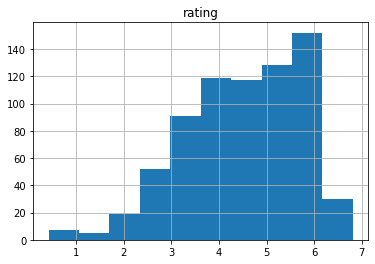

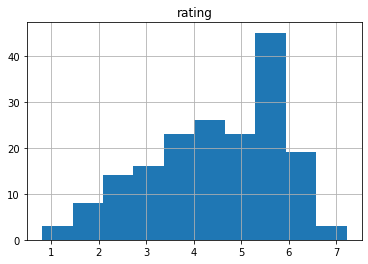

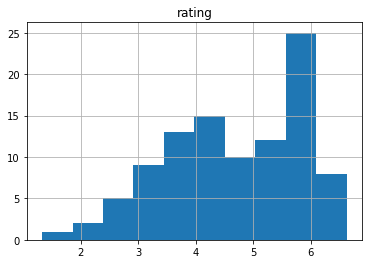

In [ ]:
df_train[['rating']].hist(), df_valid[['rating']].hist(), df_test[['rating']].hist()
df_train.describe() 

### Create the model

In [ ]:
from nima.model.model_builder import NIMA
from nima.config import INPUT_SHAPE, CROP_SHAPE
from tensorflow.keras.losses import mean_squared_error

# Form the NIMA Aesthetic Model
nima_technical_cnn = NIMA(base_model_name=p_model_name, model_type='technical',
                            input_shape=INPUT_SHAPE, metrics=p_metrics)

# Build the model for training
nima_technical_cnn.build()
nima_technical_cnn.compile()
nima_technical_cnn.model.summary()

	NIMA Base CNN module - tensorflow.keras.applications.vgg19.VGG19
	Freezing base CNN layers.
	Model compiled successfully.
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
__

### Create Model

##### Train the model

	Figure path : C:\Users\amaindola\Google Drive\Colab Notebooks\img-quality-assesment\nima\weights\VGG19_technical_all-freezed
	Model Weight path : C:\Users\amaindola\Google Drive\Colab Notebooks\img-quality-assesment\nima\weights\VGG19_technical_all-freezed
Epoch 1/5
12/12 [==============================] - 206s 16s/step - loss: 0.8527 - mean_absolute_error: 0.8527 - val_loss: 0.5935 - val_mean_absolute_error: 0.5935


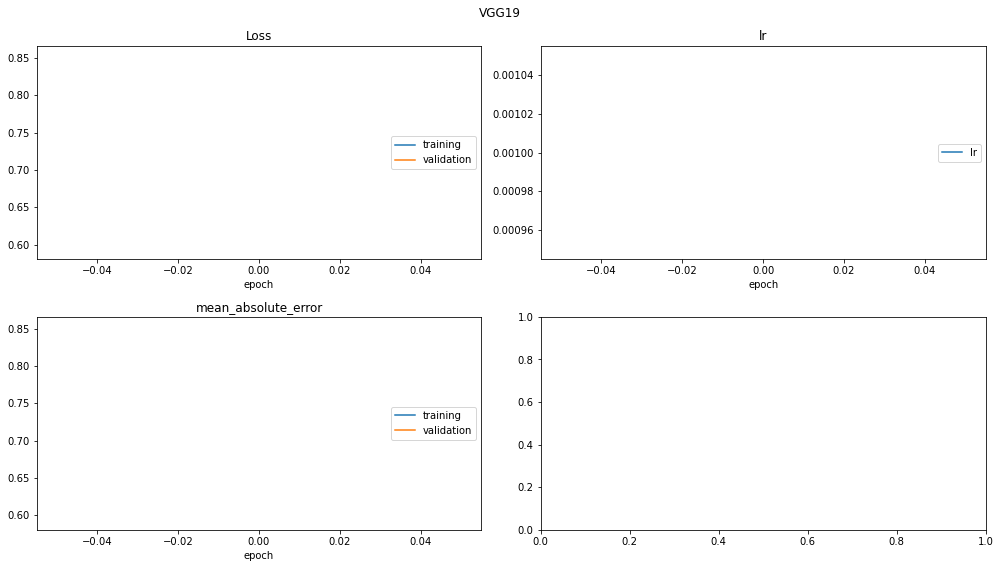

Epoch 2/5
12/12 [==============================] - 199s 16s/step - loss: 0.3604 - mean_absolute_error: 0.3604 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911


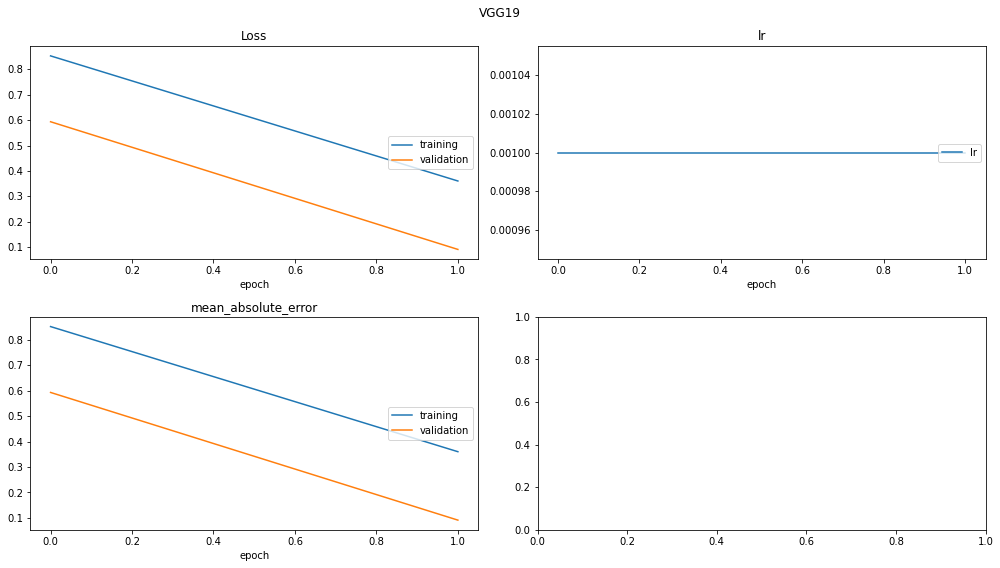

Epoch 3/5
12/12 [==============================] - 214s 17s/step - loss: 0.3193 - mean_absolute_error: 0.3193 - val_loss: 0.0078 - val_mean_absolute_error: 0.0078


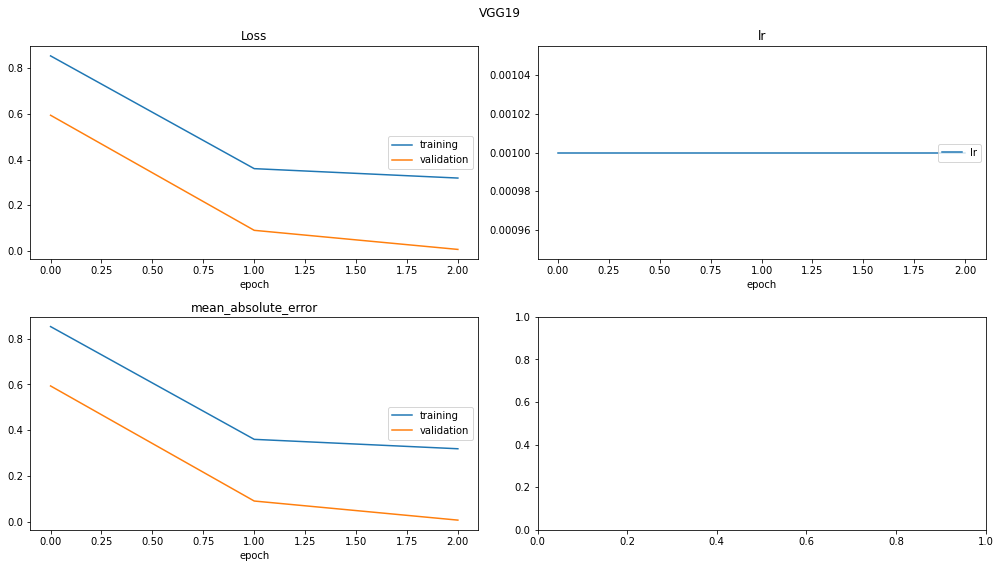

Epoch 4/5
12/12 [==============================] - 217s 18s/step - loss: 0.2653 - mean_absolute_error: 0.2653 - val_loss: 0.1518 - val_mean_absolute_error: 0.1518


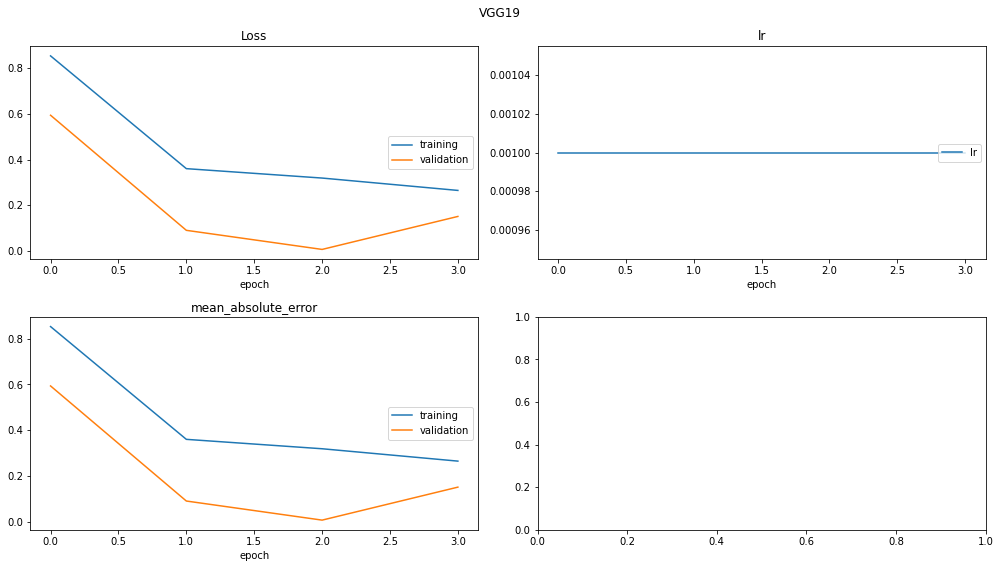

Epoch 5/5
12/12 [==============================] - 215s 17s/step - loss: 0.2444 - mean_absolute_error: 0.2444 - val_loss: 0.0889 - val_mean_absolute_error: 0.0889

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


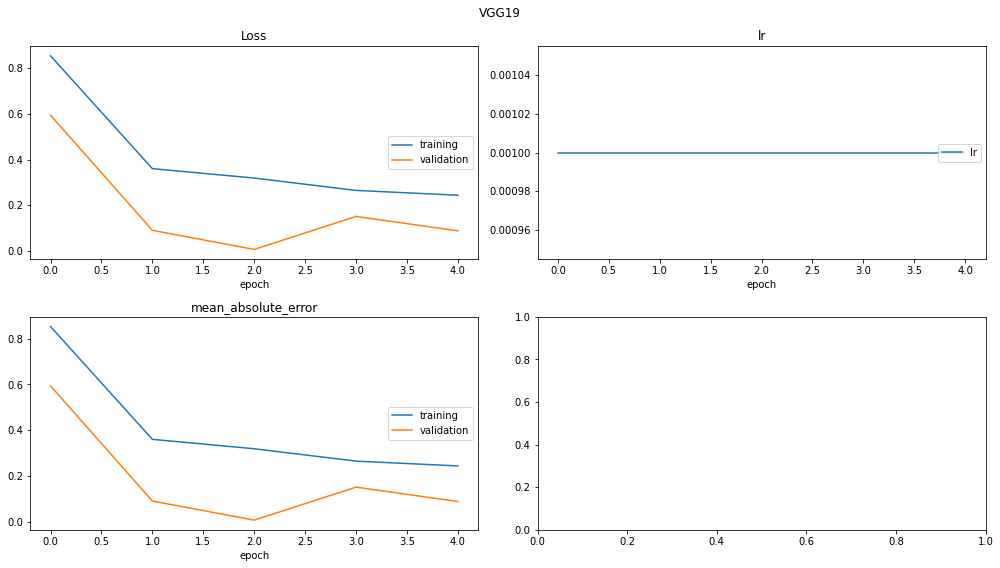

	Training Time (HH:MM:SS) : 00:17:48


ValueError: too many values to unpack (expected 2)

In [ ]:
train_result_df = nima_technical_cnn.train_model(train_generator, valid_generator,
                                                 epochs=p_epochs, verbose=p_verbose)


#### Test the model

In [ ]:
from nima.model.data_generator import TestDataGenerator

# Get the generator
test_generator = TestDataGenerator(df_test, tid_images_dir, x_col=x_col, y_col=None,
                                   img_format=img_format, num_classes=1,
                                   preprocess_input=nima_technical_cnn.get_preprocess_function(),
                                   batch_size=test_batch_size, input_size=INPUT_SHAPE)

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_steps = np.ceil(len(test_generator))
print_msg(f'Testing Batch size:{test_batch_size}, steps:{test_steps}', 1)

predictions = nima_technical_cnn.model.predict(test_generator)
df_test['rating_predict'] = predictions

df_test[['image_id', 'rating', 'rating_predict']]

	Found 100 valid image filenames belonging to 1 classes.
	Testing Batch size:32, steps:4.0


,image_id,rating,rating_predict
0,i05_23_2,5.57500,0.778178
1,i21_24_2,5.72093,0.784853
2,i22_10_3,5.00000,0.790560
3,i12_08_1,6.18421,0.784738
4,i01_08_4,3.00000,0.792191
...,...,...,...
95,i07_02_2,5.86364,0.787550
96,i14_12_1,5.81081,0.775977
97,i25_05_2,5.25714,0.773710
98,i07_06_5,3.31818,0.788431


#### Test the model for one image

In [ ]:
loss, acc = nima_technical_cnn.model.evaluate(test_generator)
loss, acc

ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.

In [ ]:
from nima.utils import image_utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = df_test.iloc[0]['image_id']
y_true = df_test.iloc[0]['rating']

image_path = os.path.join(tid_images_dir, f'{image}.bmp')
plt.imshow(x)
target_size = INPUT_SHAPE

x = load_img(image_path, target_size=(target_size[0], target_size[1]))  # load the image in pillow format
x = img_to_array(x)  # convert to numpy array
x = x.reshape(1, *x.shape)
x = nima_technical_cnn.preprocess_input(x)
predict = nima_technical_cnn.model.predict(x)
y_true, predict[0]

(5.575, array([8.660821], dtype=float32))